In [ ]:
## Import libraries

import warnings
warnings.filterwarnings('ignore')
import os
from PIL import Image
import pathlib
import csv

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import librosa
import librosa.display
from tqdm import tqdm

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

from IPython import display
from sklearn.model_selection import train_test_split


# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Functions

In [ ]:
def get_dataset(folder_path_str: str=None)-> pd.DataFrame:
    """
    :param folder_path_str: folder path where audio files populated
    :result: pandas dataframe -> mapping audio files by city, gender and path files within pandas dataframe
    """
    dataset_ = list()
    for city in os.listdir(folder_path_str):
        for gender in os.listdir(os.path.join(folder_path_str, city)):
            files_list = os.listdir(os.path.join(folder_path_str, city, gender))
            files = [os.path.join(folder_path_str, city, gender, file_) for file_ in files_list]
            dataset_.append({"city":city, 'gender':gender, 'files':files})
    result = pd.DataFrame(dataset_).explode("files").reset_index(drop=True)
    result.to_csv(os.path.join(folder_path_str, "dataset.csv"), index=False)
    return result

In [ ]:
# def split_data_audio(df, threshold=0.7):
#     grp_ = df.groupby(['city', 'gender'])
#     df['index'] = grp_.cumcount()
#     df_thres = grp_.agg(tot_file_thres=('files', 'count'))*threshold
#     df = df.join(df_thres, on=['city', 'gender'], how="left")
#     df['split_label'] = np.where(df['index']<df['tot_file_thres'], 'train', 'test')
#     df = df.drop(['index', 'tot_file_thres'],axis=1)
#     return df

# Load datasets

 - First of all, kita harus meng-load dataset dan mengubahnya menjadi kumpulan array yang dimana array tersebut telah ditransformasikan menjadi kumpulan audio features yang berjumlah 40 features dengan mengunakan MFCC method


In [ ]:
## Folder path locations
folder_path_str = '/content/drive/MyDrive/Data Suara buat Adam'
df = pd.read_csv(os.path.join(folder_path_str, 'dataset.csv'))
## Drop bekasi
df = df[df['city']!='Data Bekasi'].reset_index(drop=True)

In [ ]:
## Transform class name string to numbers (1,2,3,4)
class_dict = {i:x for x,i in enumerate(df['city'].unique())}
df['target'] = df['city'].map(class_dict)

In [ ]:
## Output
class_dict

{'Data Bandung': 0, 'Data Bogor': 1, 'Data Cirebon': 2}

In [ ]:
X_ = []
y_ = []
for ix, data in tqdm(df.iterrows(),  desc='Progress'):
    ## Reading audio files -> wav file to array
    ## ISSUES : Only getting first 8 seconds due to standardize issue when collect the data
    sig, sr = librosa.load(data['files'], offset=1, duration=8)
    ## Generate 40 audio features using mfcc methods
    mfcc_ = librosa.feature.mfcc(y=sig , sr=sr, n_mfcc=40)
    ## Populate each tranformed features to list
    X_.append(mfcc_)
    y_.append(data['target'])

## List of arrays of each audio
X_np = np.array(X_)
y_np = np.array(y_)

Progress: 150it [01:44,  1.44it/s]


In [ ]:
len(sig)

176400

In [ ]:
X_np.shape

(150, 40, 345)

In [ ]:
## Save to numpy file
np.save(os.path.join(folder_path_str, 'data.npy'), X_np)
np.save(os.path.join(folder_path_str, 'target.npy'), y_np)

In [ ]:
## Load datasets
X = np.load(os.path.join(folder_path_str, 'data.npy'))
y = np.load(os.path.join(folder_path_str, 'target.npy'))

#### NOTES
1. We are unable to do audio processing due to data quality issues.
2. We are only looking at the first 8 sec of the audio -> Slightly we'll get the same time of the sentence - I did cherry picking to getting the first 8 sec
---------------------------
#### ISSUES - Data collection
1. No standardize of the time interval
2. Taking audio in noisy place
3. The people are mostly having the same race

# Preprocessing

- Setelah feature ditransformaskan dan dikumpulkan menjadi kumpulan array dari setiap data pada variable X, kita melakukan beberapa pedekatan sebelum dimasukkan kedalam model machine learning.
- Pendekatan yang dilakukan ialah,
    1. Menambahkan 1 channel yang merepsentasikan jumlah dimensi pada array tersebut, yaitu 1 dimensi.
    2. Mentansformasikan setiap variable class/ target menjadi multi classes variable.
    3. Memisahkan dataset menjadi data latih dan data test dengan ratio 80% untuk data latih dan 20% untuk data test  dari 150 total data

In [ ]:
X.shape

(150, 40, 345)

In [ ]:
## Adding 1 channel which represents total dimension of tensor
X = X_np.reshape(X_np.shape[0], X_np.shape[1], X_np.shape[2], 1)

## Transforming each value of class variable to multi-class label
##
## Example: We had 3 classes {'Data Bandung': 0, 'Data Bogor': 1, 'Data Cirebon': 2}
##
## Before:
##          Label = 0, 1, 2
## Result:
##          Label = [1, 0, 0], [0, 1, 0], [0, 0, 1]

y = tf.keras.utils.to_categorical(y_np , num_classes=3)

In [ ]:
X.shape

(150, 40, 345, 1)

In [ ]:
## Spliting the dataset (80% data train and 20% data test)
X_train , X_test , y_train , y_test = train_test_split(X , y ,test_size=0.2, random_state=42)

In [ ]:
## Set up the shape for input layer
INPUT_SHAPE = (40,345,1)

# Modelling

Pada proses ini kita menggunakan konseptual Conventional Neural Network untuk membentuk arsitektur deep learning model untuk dapat melakukan klasifikasi audio terhadap data latih yang sebelumnya telah diolah

In [ ]:
model =  models.Sequential(
    [layers.Conv2D(32 , (3,3),activation = 'relu',padding='valid', input_shape = INPUT_SHAPE),
     layers.MaxPooling2D(2, padding='same'),
     layers.Dropout(0.3),
     layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
     layers.MaxPooling2D(2, padding='same'),
     layers.Dropout(0.3),
     layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
     layers.MaxPooling2D(2, padding='same'),
     layers.Dropout(0.3),
     layers.GlobalAveragePooling2D(),
     layers.Dense(64, activation = 'relu'),
     layers.Dropout(0.3),
     layers.Dense(3, activation = 'softmax')
])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 343, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 172, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 172, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 170, 128)      36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 85, 128)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 85, 128)        0

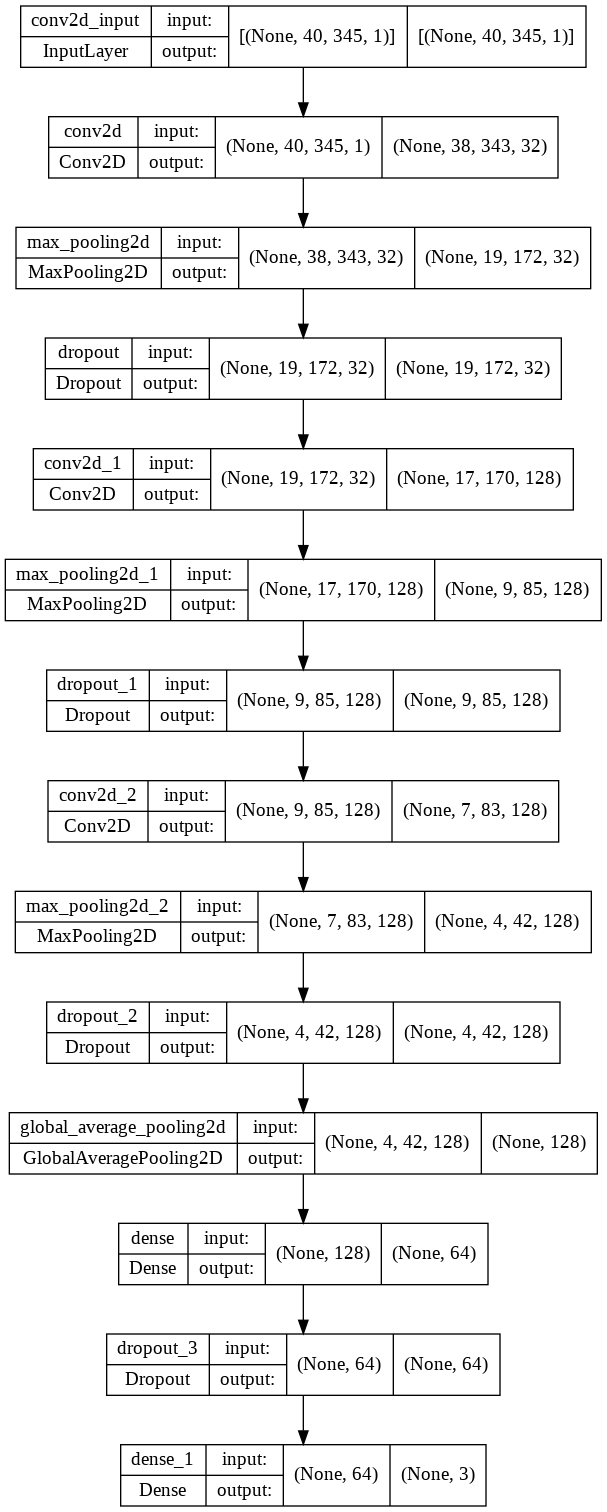

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
## Early stopping  -> to stopping the training if there is no improvement on val_acc or acc
## Early stopping is able to avoid overfit
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=9, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

## Training the model
history = model.fit(X_train, y_train,
            validation_data=(X_test,y_test),
            epochs=199,
            callbacks = [callback],
            )

Epoch 1/199
4/4 [==============================] - 16s 459ms/step - loss: 3.5886 - acc: 0.3750 - val_loss: 1.1274 - val_acc: 0.3667
Epoch 2/199
4/4 [==============================] - 0s 29ms/step - loss: 1.5667 - acc: 0.3750 - val_loss: 1.1164 - val_acc: 0.3667
Epoch 3/199
4/4 [==============================] - 0s 29ms/step - loss: 1.4538 - acc: 0.3250 - val_loss: 1.1172 - val_acc: 0.2000
Epoch 4/199
4/4 [==============================] - 0s 28ms/step - loss: 1.2028 - acc: 0.3083 - val_loss: 1.1293 - val_acc: 0.1667
Epoch 5/199
4/4 [==============================] - 0s 28ms/step - loss: 1.1353 - acc: 0.3750 - val_loss: 1.1155 - val_acc: 0.3000
Epoch 6/199
4/4 [==============================] - 0s 28ms/step - loss: 1.1111 - acc: 0.3083 - val_loss: 1.1049 - val_acc: 0.1667
Epoch 7/199
4/4 [==============================] - 0s 29ms/step - loss: 1.0927 - acc: 0.3667 - val_loss: 1.1043 - val_acc: 0.4333
Epoch 8/199
4/4 [==============================] - 0s 29ms/step - loss: 1.1203 - acc: 0.

# Model Performance

- Kita akan melihat model performance dengan menggunakan metrics yaitu sebagai berikut:
        1. Acurracy
        2. Loss / Error Value
        3. Confusion Matrix

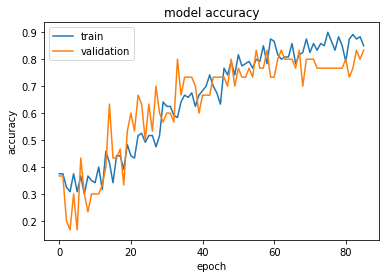

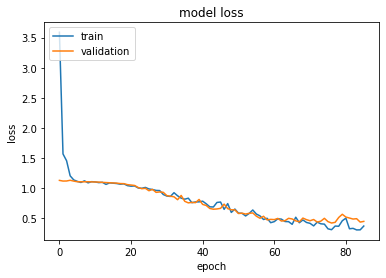

In [ ]:
## Visualize performance

## Accuracy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Loss / Error value

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
## Confusion Matrix

from sklearn.metrics import confusion_matrix #import Confusion Matrix function
import itertools #fungsi iterasi membuat looping menjadi efisien

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    # plt.grid('off')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

1/1 [==============================] - 0s 492ms/step


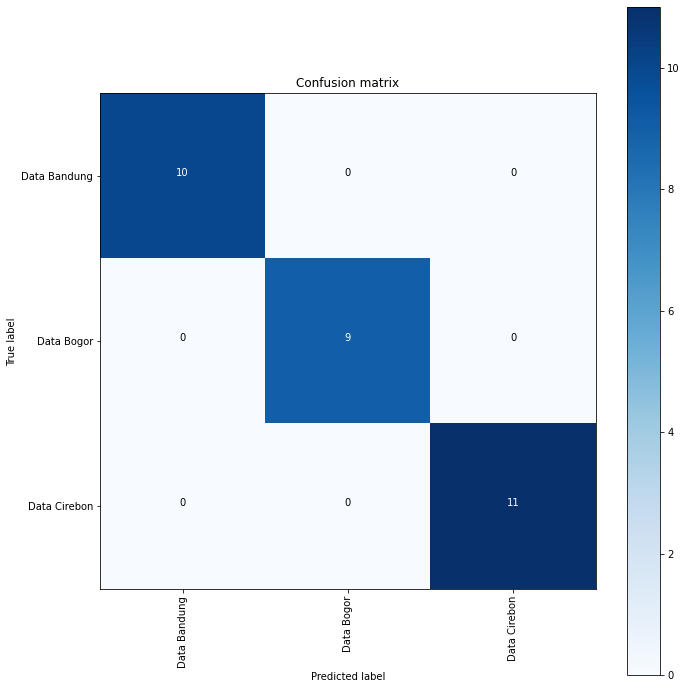

In [ ]:
class_name = [i for i in class_dict.values()]
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_test, axis = 1)
confusion_mtx = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = class_dict)

In [ ]:
## Save model
model.save(f'{folder_path_str}/model.h5')

## Load Model

In [ ]:
model = models.load_model(f'{folder_path_str}/model.h5')

## requirements
1. install python3
2. install pip -> pip3
3. recommendation -> set virtual environtment : python3 -m venv [location venv folder]; run : source [location venv folder] /bin/activate
4.
    - pip install --upgrade
    - pip install numpy
    - pip install tensorflow
    - pip install librosa

5. python3 predict.py

----------

e.g = project_env
1. python3 -m venv project_env
2. source project_env/bin/activate
output = (project_env) /usr/bin/:
3. deactivate -> Matiin environtment

In [ ]:
import numpy as np
import librosa
from tensorflow.keras import models

class AudioPrediction:
    def __init__(self, file_path, model_path, class_dict):
        self.file_path = file_path
        self.model_path = model_path
        self.class_dict = class_dict

    def load_data(self):
        sig , sr = librosa.load(self.file_path, offset=1, duration=8)
        mfcc_ = librosa.feature.mfcc(sig , sr=sr, n_mfcc=40)
        arr_ = np.array(mfcc_)
        return arr_.reshape(1, arr_.shape[0], arr_.shape[1], 1)

    def load_model(self):
        return models.load_model(self.model_path)

    def main(self):
        model = self.load_model()
        X = self.load_data()
        y_score = model.predict(X)
        y = np.argmax(y_score, axis = 1)[0]
        label_prediction = self.class_dict[y]
        score = np.max(y_score)
        print(f'Prediksi: {label_prediction} \nScore: {score}')
        return label_prediction, score

if __name__ == '__main__':
    ## Ganti file path
    file_path = '/content/drive/MyDrive/Data Suara buat Adam/Data Bogor/Perempuan/PTT-20220529-WA0012.wav'
    ## Ganti model path
    model_path = '/content/drive/MyDrive/Data Suara buat Adam/model.h5'

    class_dict = {0: 'Data Bandung', 1: 'Data Bogor', 2: 'Data Cirebon'}

    audioPrediction = AudioPrediction(file_path=file_path, model_path=model_path, class_dict=class_dict)
    a, b = audioPrediction.main()

1/1 [==============================] - 0s 95ms/step
Prediksi: Data Bogor 
Score: 0.6613972783088684


In [ ]:
a

'Data Bogor'

In [ ]:
b

0.6613973

## Data Visualization

In [ ]:
df

,city,gender,files,target
0,Data Bandung,Laki-Laki,/content/drive/MyDrive/Data Suara buat Adam/Da...,0
1,Data Bandung,Laki-Laki,/content/drive/MyDrive/Data Suara buat Adam/Da...,0
2,Data Bandung,Laki-Laki,/content/drive/MyDrive/Data Suara buat Adam/Da...,0
3,Data Bandung,Laki-Laki,/content/drive/MyDrive/Data Suara buat Adam/Da...,0
4,Data Bandung,Laki-Laki,/content/drive/MyDrive/Data Suara buat Adam/Da...,0
...,...,...,...,...
145,Data Cirebon,Perempuan,/content/drive/MyDrive/Data Suara buat Adam/Da...,2
146,Data Cirebon,Perempuan,/content/drive/MyDrive/Data Suara buat Adam/Da...,2
147,Data Cirebon,Perempuan,/content/drive/MyDrive/Data Suara buat Adam/Da...,2
148,Data Cirebon,Perempuan,/content/drive/MyDrive/Data Suara buat Adam/Da...,2


In [ ]:
sample = df.groupby(['city', 'gender']).head(2).reset_index()

In [ ]:
sample

,index,city,gender,files,target
0,0,Data Bandung,Laki-Laki,/content/drive/MyDrive/Data Suara buat Adam/Da...,0
1,1,Data Bandung,Laki-Laki,/content/drive/MyDrive/Data Suara buat Adam/Da...,0
2,25,Data Bandung,Perempuan,/content/drive/MyDrive/Data Suara buat Adam/Da...,0
3,26,Data Bandung,Perempuan,/content/drive/MyDrive/Data Suara buat Adam/Da...,0
4,50,Data Bogor,Laki-Laki,/content/drive/MyDrive/Data Suara buat Adam/Da...,1
5,51,Data Bogor,Laki-Laki,/content/drive/MyDrive/Data Suara buat Adam/Da...,1
6,75,Data Bogor,Perempuan,/content/drive/MyDrive/Data Suara buat Adam/Da...,1
7,76,Data Bogor,Perempuan,/content/drive/MyDrive/Data Suara buat Adam/Da...,1
8,100,Data Cirebon,Laki-Laki,/content/drive/MyDrive/Data Suara buat Adam/Da...,2
9,101,Data Cirebon,Laki-Laki,/content/drive/MyDrive/Data Suara buat Adam/Da...,2


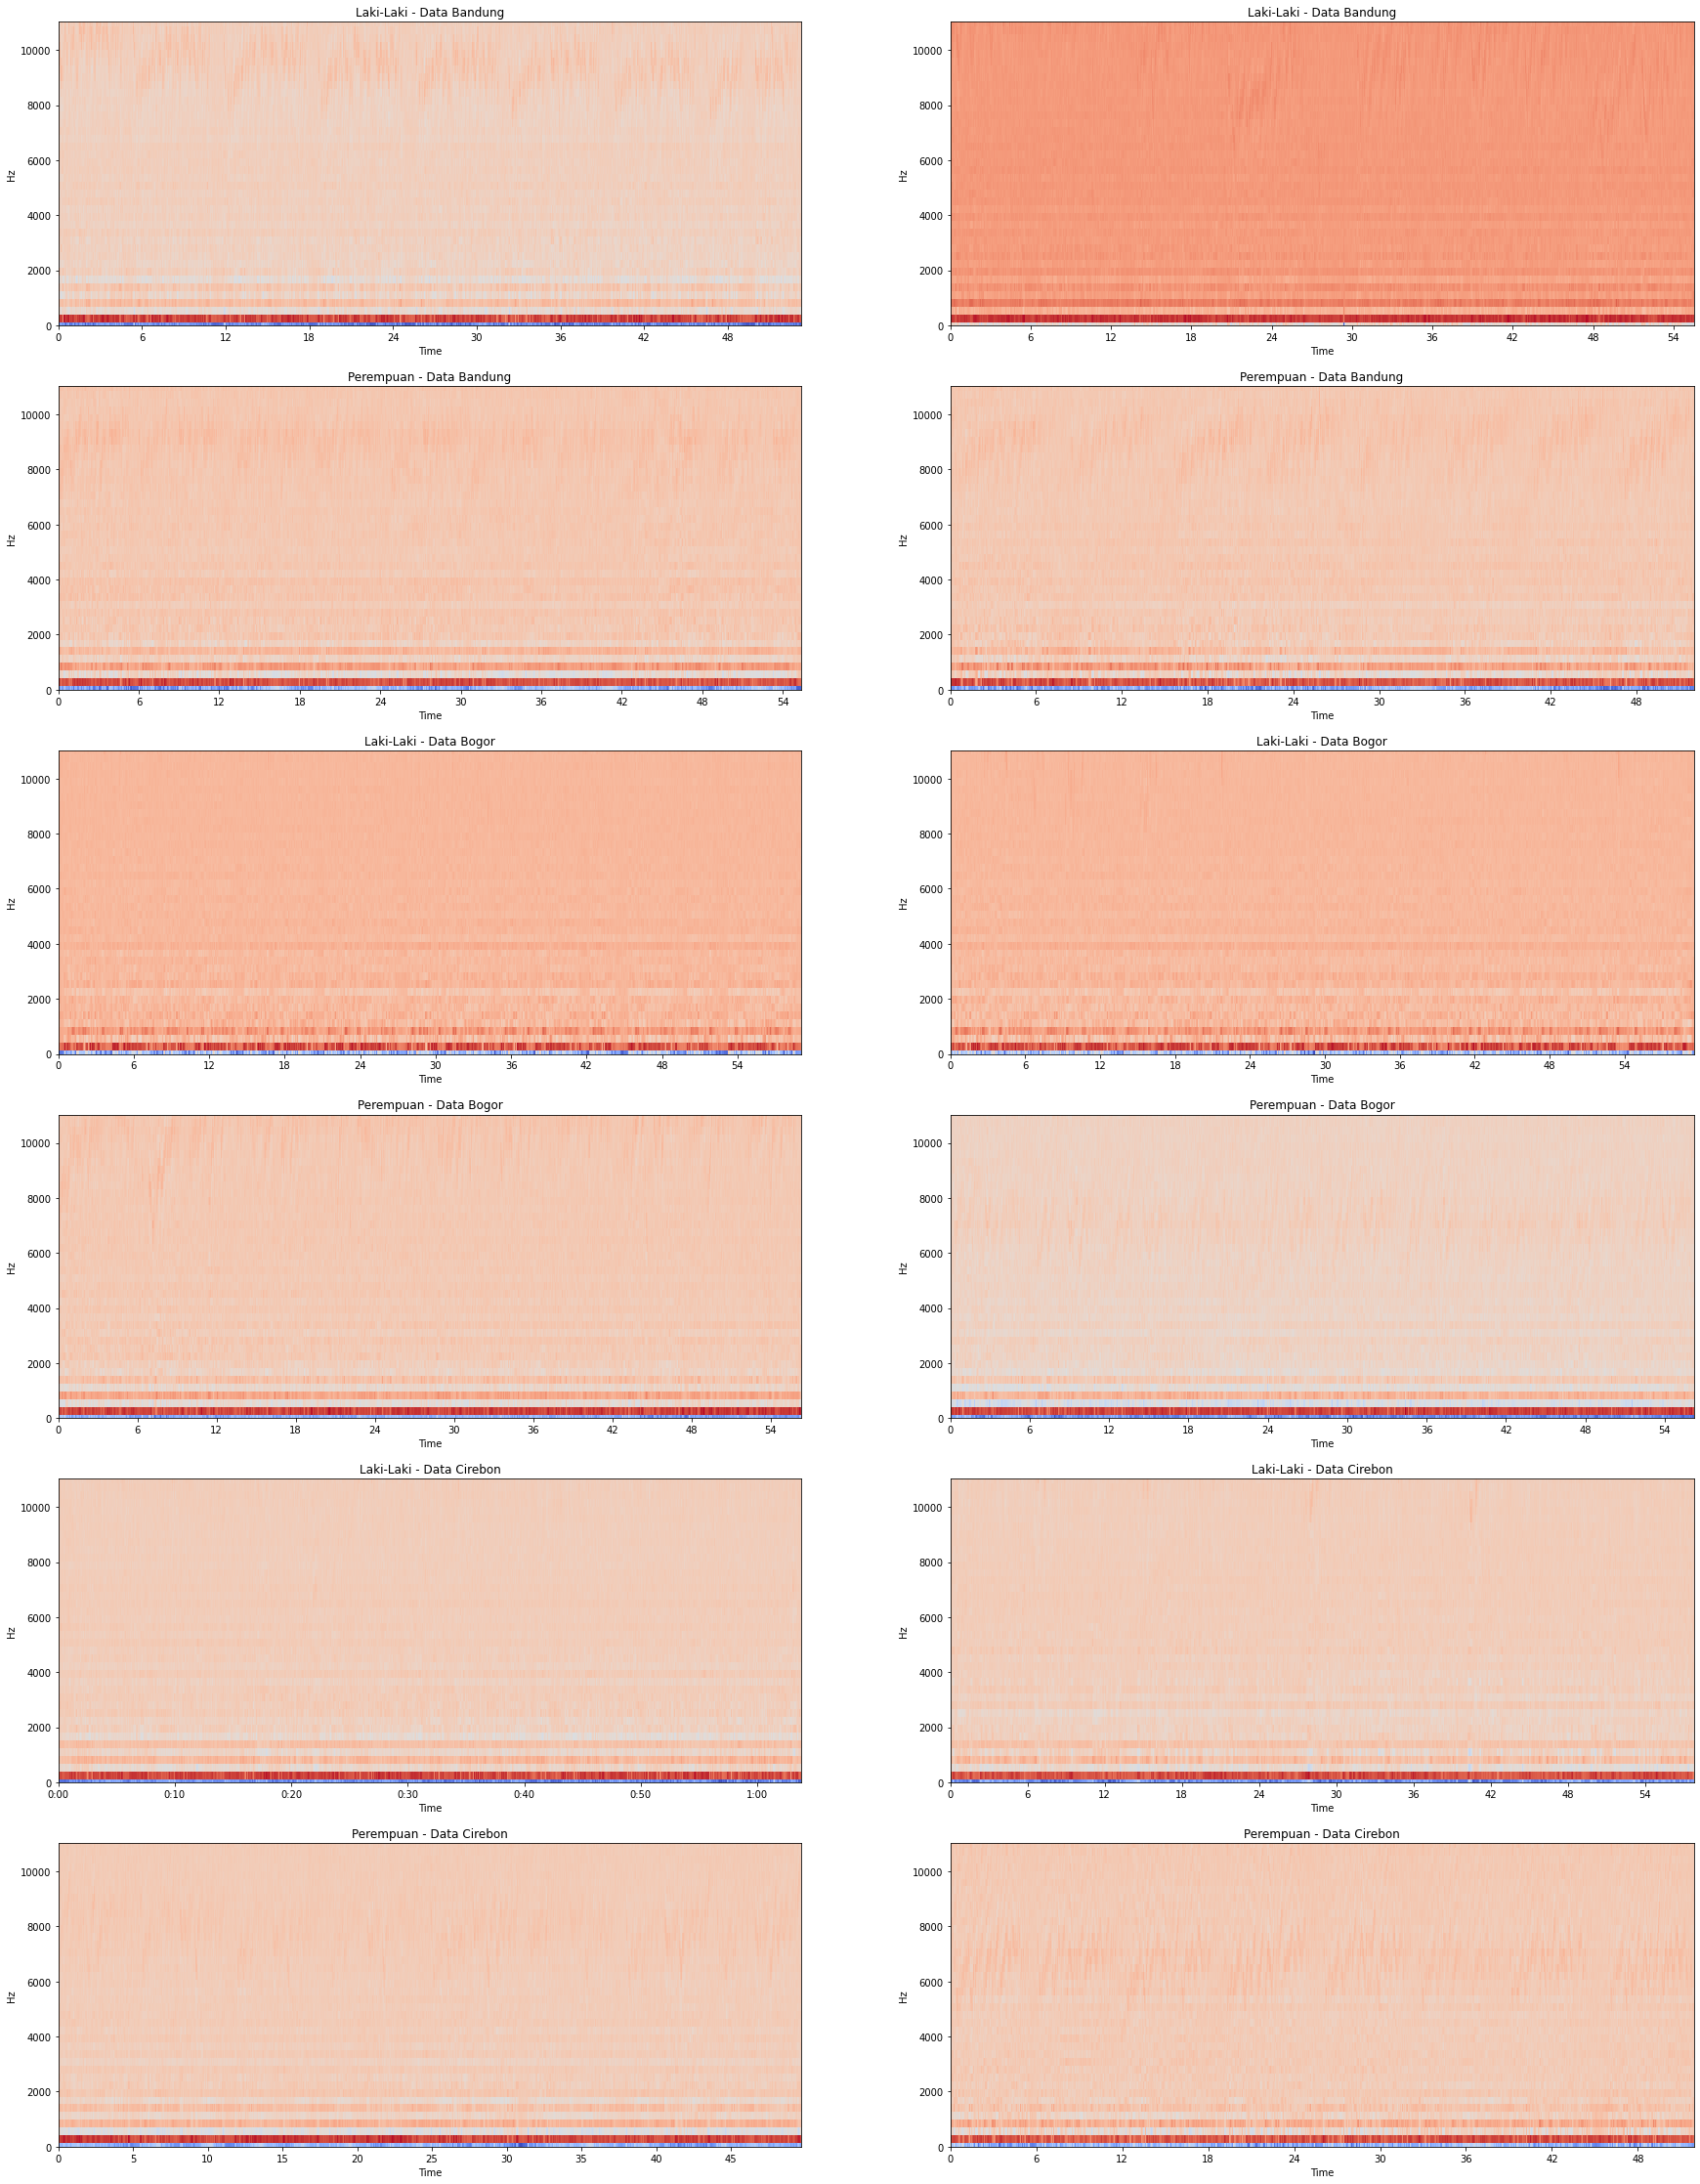

In [ ]:
rows = 6
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(30, 40))
for x, i in sample.iterrows():
    r = x // cols
    c = x % cols
    sig , sr = librosa.load(i['files'], offset=1)
    mfcc_ = librosa.feature.mfcc(sig , sr=sr, n_mfcc=40)
    ax = axes[r][c]
    # if i['gender']=='Perempuan':
    #     ax = axes[r][0]
    # if i['gender']=='Laki-Laki':
    #     ax = axes[r][1]
    librosa.display.specshow(mfcc_, sr=sr, x_axis='time', y_axis='hz', ax=ax)
    ax.set_title(i['gender'] + ' - ' +i['city'])

# plt.show()